get some proteins sequences from one of jeppe's data files

In [1]:
import numpy as np
import torch
import imp
import re
from torch.nn.utils.rnn import pad_sequence

In [30]:
aa_id_dict = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
              'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 
              'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}


In [29]:
def aa_to_onehot(aa_str, aa_to_nr, mask=None):
    if mask!=None:
        mask_ind = np.asarray([x=='+' for x in mask])*1
        mask_ind = np.nonzero(mask_ind)
        aa_str = "".join([aa_str[x] for x in mask_ind[0]]) # because it gets put in another list
    init_array = np.zeros( (len(aa_to_nr.keys()), len(aa_str)) )
    for i,j in enumerate(aa_str):
        init_array[aa_to_nr[j], i] = 1
    return(init_array)

In [19]:
def read_proteinnet_file(file, stop_at=1000):
    protein_dict = {}
    with open(file) as input:
        lines = input.readlines()
        curr_id = None
        for i, line in enumerate(lines):
            line = line.strip()
            if line == '[ID]':
                curr_id = lines[i+1].strip()
                protein_dict[curr_id] = {}
                protein_dict[curr_id]['primary'] = lines[i+3].strip()
            if line == '[TERTIARY]':
                coords = []
                for j in range(3):
                    coords.append(np.fromstring(lines[i+j+1], sep='\t'))
                protein_dict[curr_id]['tertiary'] = np.array(coords)
            if line == '[MASK]':
                protein_dict[curr_id]['mask'] = lines[i+1].strip()
            if len(protein_dict.keys()) >= stop_at:
                break
    filter_seqs(protein_dict)
    return(protein_dict)

In [22]:
def filter_coords(coords, mask):
    mask = np.array([x=='+' for x in mask])
    mask_stretched = np.repeat(mask, 3)
    coords_filt = coords[:, mask_stretched]
    return(coords_filt)

def filter_seqs(protein_dict):
    re_chainbreak = re.compile("\-*\+*\+\-+\+\+*\-*")
    keys_to_remove = {}
    for key in protein_dict.keys():
        if len(protein_dict[key].keys()) < 3:
            keys_to_remove[key] = ' missing structure, removing...'
            continue
        mask = protein_dict[key]['mask']
        if re_chainbreak.search(mask):
            keys_to_remove[key] = " has a chainbreak, removing..."
        else:
            coords = protein_dict[key]['tertiary']
            coords_filt = filter_coords(coords, mask)
            protein_dict[key]['tertiary'] = coords_filt
    for key in keys_to_remove.keys():
        print(key, keys_to_remove[key])
        del protein_dict[key]

def new_dihedral(p0, p1, p2, p3): # COPY PASTA'D FROM STACKEXCHANGE
    """Praxeolitic formula
    1 sqrt, 1 cross product"""

    b0 = -1.0*(p1 - p0)
    b1 = p2 - p1
    b2 = p3 - p2

    # normalize b1 so that it does not influence magnitude of vector
    # rejections that come next
    b1 /= np.linalg.norm(b1)

    # vector rejections
    # v = projection of b0 onto plane perpendicular to b1
    #   = b0 minus component that aligns with b1
    # w = projection of b2 onto plane perpendicular to b1
    #   = b2 minus component that aligns with b1
    v = b0 - np.dot(b0, b1)*b1
    w = b2 - np.dot(b2, b1)*b1

    # angle between v and w in a plane is the torsion angle
    # v and w may not be normalized but that's fine since tan is y/x
    x = np.dot(v, w)
    y = np.dot(np.cross(b1, v), w)
    #return np.degrees(np.arctan2(y, x))
    return np.arctan2(y, x)

def calc_angles(coords):
    N = coords.shape[1]
    angles_all = []
    for i in range(0, N-3, 3):
        psi = new_dihedral(*[coords[:, x] for x in range(i, i+4)])
        omega = new_dihedral(*[coords[:, x] for x in range(i+1, i+5)])
        phi = new_dihedral(*[coords[:, x] for x in range(i+2, i+6)])
        angles = [psi, omega, phi]
        angles_all.append(angles)
    return(np.array(angles_all))

In [23]:
some_proteins = read_proteinnet_file('/Users/Deathvoodoo/big_folders_msc/data/casp7/training_70')

2G6Y_1_A  has a chainbreak, removing...
1NNX_1_A  has a chainbreak, removing...
1FL1_1_A  has a chainbreak, removing...
1OYS_1_A  has a chainbreak, removing...
1YFS_d1yfsb1  has a chainbreak, removing...
1ZNN_d1znnf-  has a chainbreak, removing...
1DL3_1_A  has a chainbreak, removing...
1EMS_1_A  has a chainbreak, removing...
1YSR_1_A  has a chainbreak, removing...
1TFF_1_A  has a chainbreak, removing...
1V39_1_A  has a chainbreak, removing...
1X2G_1_A  has a chainbreak, removing...
1ZAO_d1zaoa2  has a chainbreak, removing...
2FIY_1_A  has a chainbreak, removing...
1HYV_1_A  has a chainbreak, removing...
1JDP_1_A  has a chainbreak, removing...
1X7F_d1x7fa2  has a chainbreak, removing...
1D9Z_1_A  has a chainbreak, removing...
1NH9_1_A  has a chainbreak, removing...
1UN8_d1un8b1  has a chainbreak, removing...
1I7G_1_A  has a chainbreak, removing...
1AU7_3_A  has a chainbreak, removing...
1MZB_1_A  has a chainbreak, removing...
1FOT_1_A  has a chainbreak, removing...
1SKQ_1_A  has a chai

In [16]:
has_mask = []
for key in some_proteins.keys():
    if not 'mask' in some_proteins[key].keys():
        has_mask.append(key)

In [25]:
# check how big the proteins are, dont wanna pad a million zeroes
keylengths=[len(some_proteins[key]['primary']) for key in some_proteins.keys()]
max(keylengths)

1246

In [31]:
max_length = 1500
sequence_list = []
angle_list = []
for key in some_proteins.keys():
    sequence = aa_to_onehot(some_proteins[key]['primary'], aa_id_dict, some_proteins[key]['mask'])
    coords = some_proteins[key]['tertiary']
    angles = calc_angles(coords).T
    if max_length-sequence.shape[0] < 0:
        print(key, ' exceeds max length: ', max_length, ' , skipping...')
        continue
    else:
        sequence_padded = np.pad(sequence, pad_width=((0,0), (0, max_length-sequence.shape[1])), constant_values=0)
        sequence_list.append(sequence_padded)
        angles_padded = np.pad(angles, pad_width=((0,0), (0, max_length-sequence.shape[1])), constant_values=0)
        angle_list.append(angles_padded)
print(np.array(sequence_list).shape)
print(np.array(angle_list).shape)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


(805, 20, 1500)
(805, 3, 1499)


In [50]:
N = len(sequence_list)
have_nans = []
for i,j in enumerate(angle_list):
    if np.isnan(j).any():
        have_nans.append(i)

In [67]:
sequence_tensor = torch.tensor(sequence_list).float()
sequence_tensor = sequence_tensor.unsqueeze(1)
angle_tensor = torch.tensor(angle_list).float()
angle_tensor = angle_tensor.unsqueeze(1)

In [68]:
inds_to_keep = np.logical_not(np.isin(np.arange(N), have_nans))
sequence_tensor = sequence_tensor[inds_to_keep, :, :, :]
angle_tensor = angle_tensor[inds_to_keep, :, :, :]

In [69]:
def split_inds(N, train_fraction, validation_fraction):
    indices = np.arange(N)
    train_to = int(np.floor(len(indices)*train_fraction))
    train_inds = indices[0: train_to]
    val_to = int(np.floor(len(indices)*(train_fraction+validation_fraction)))
    val_inds = indices[train_to: val_to]
    test_inds = indices[val_to:]
    return(train_inds, val_inds, test_inds)

In [70]:
train_inds, val_inds, test_inds = split_inds(angle_tensor.shape[0], 0.8, 0.1)

train_data = [sequence_tensor[train_inds, :, :, :], angle_tensor[train_inds, :, :, :]]
val_data = [sequence_tensor[val_inds, :, :, :], angle_tensor[val_inds, :, :, :]]
test_data = [sequence_tensor[test_inds, :, :, :], angle_tensor[test_inds, :, :, :]]

In [71]:
from IPython.core.debugger import set_trace

In [72]:
from torch.utils.data import Dataset
class proteindataset(Dataset):
    def __init__(self, seqs, angles):
        self.sequences = seqs
        self.angles = angles

    def __len__(self):
        return self.sequences.shape[0]

    def __getitem__(self, idx):
        return [self.sequences[idx, :, :, :], self.angles[idx, :, :, :]]
    
class proteindataset2(Dataset): # needs to be fixed
    def __init__(self, ids):
        self.ids = ids # should be np.array
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        id_sub = self.ids[idx]
        seq_string = seqs[id_sub]['primary']
        sequence =  aa_to_onehot(seq_string, aa_id_dict, seqs[id_sub]['mask'])
        coords = seqs[id_sub]['tertiary']
        angles = calc_angles(coords).T
        seq_tensor = torch.tensor(sequence).float().unsqueeze(0)
        angle_tensor = torch.tensor(angles).float().unsqueeze(0)
        return [seq_tensor.unsqueeze(0), angle_tensor.unsqueeze(0)]

In [73]:
train_dataset = proteindataset(train_data[0], train_data[1])
val_dataset = proteindataset(val_data[0], val_data[1])
test_dataset = proteindataset(test_data[0], test_data[1])

In [76]:
id_array = np.array(list(some_proteins.keys()))
train_dataset2 = proteindataset2(id_array[train_inds])

In [99]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=100,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=100,
                                         shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=100,
                                         shuffle=False, num_workers=2)

In [100]:
trainloader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=4,
                                          shuffle=True, num_workers=2)


In [105]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(1, 3, (20, 1))
        self.conv1 = nn.Conv2d(3, 6, (1, 6)) #in, out, kernel size (can be 1 number)
        self.conv2 = nn.Conv2d(6, 12, (1, 8))
        self.conv3 = nn.Conv2d(12, 24, (1, 10))
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=24, out_channels=12, kernel_size=(1, 10))
        self.deconv2 = nn.ConvTranspose2d(in_channels=24, out_channels=6, kernel_size=(1, 8))
        self.deconv3 = nn.ConvTranspose2d(in_channels=12, out_channels=1, kernel_size=(3, 5))

    def forward(self, x):
        conv0_out = F.relu(self.conv0(x))
        conv1_out = F.relu(self.conv1(conv0_out))
        conv2_out = F.relu(self.conv2(conv1_out))
        conv3_out = F.relu(self.conv3(conv2_out))

        deconv1_out = self.deconv1(conv3_out)
        deconv2_input = torch.cat((conv2_out, deconv1_out), 1)
        deconv2_out = self.deconv2(deconv2_input)
        deconv3_input = torch.cat((conv1_out, deconv2_out), 1)
        deconv3_out = self.deconv3(deconv3_input)

        return deconv3_out



In [106]:
net = Net()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)
#optimizer = optim.SGD(net.parameters(), lr=1e-2)

prints_per_epoch = 3

verbose_k = np.floor(len(trainloader)/prints_per_epoch)
print(verbose_k)

losses = []
iterations = []
best_loss = None

for epoch in range(50):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
    #for i in range(52):
        #sequence = train_data[0][i, :, :, :].unsqueeze(0)
        #true_angles = train_data[1][i, :, :, :].unsqueeze(0)
        sequence, true_angles = data
        #print(sequence.shape, true_angles.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        predicted_angles = net(sequence)

        loss = criterion(predicted_angles, true_angles)
        loss.backward()
        optimizer.step()

        # print statistics, should add validation loss
        running_loss += loss.item()
        
        if (i+1) % verbose_k == 0:   
            losses.append(running_loss/verbose_k)
            true_iter = len(trainloader)*epoch + i
            iterations.append(true_iter)
            
            print('epoch: {}, iteration: {}] loss: {}'.format(epoch, i, running_loss/verbose_k))
            
            if best_loss == None:
                best_loss = running_loss/verbose_k
            else:
                if running_loss/verbose_k <= min(losses):
                    print('new best loss, saving..')
                    best_loss = running_loss/verbose_k
                    torch.save(net.state_dict(), 'best_fcn_parameters.pt')

            running_loss = 0.0

print('Finished Training')

2.0
epoch: 0, iteration: 1] loss: 0.6928243935108185
epoch: 0, iteration: 3] loss: 0.6498852670192719
new best loss, saving..
epoch: 0, iteration: 5] loss: 0.6395148038864136
new best loss, saving..
epoch: 1, iteration: 1] loss: 0.6778537631034851
epoch: 1, iteration: 3] loss: 0.6675086319446564
epoch: 1, iteration: 5] loss: 0.6085064113140106
new best loss, saving..
epoch: 2, iteration: 1] loss: 0.5809747278690338
new best loss, saving..
epoch: 2, iteration: 3] loss: 0.7080845832824707
epoch: 2, iteration: 5] loss: 0.6179108619689941
epoch: 3, iteration: 1] loss: 0.6288362145423889
epoch: 3, iteration: 3] loss: 0.6243439614772797
epoch: 3, iteration: 5] loss: 0.6206836402416229
epoch: 4, iteration: 1] loss: 0.6198828220367432
epoch: 4, iteration: 3] loss: 0.6032708585262299
epoch: 4, iteration: 5] loss: 0.5829898118972778
epoch: 5, iteration: 1] loss: 0.6351326406002045
epoch: 5, iteration: 3] loss: 0.5906074047088623
epoch: 5, iteration: 5] loss: 0.5736528635025024
new best loss, sav

In [107]:
net.load_state_dict(torch.load('/Users/Deathvoodoo/Documents/random/best_fcn_parameters.pt'))

net.eval()

validation_pred = net(val_data[0])
validation_loss = criterion(validation_pred, val_data[1])
print(validation_loss.item())

0.6038327217102051


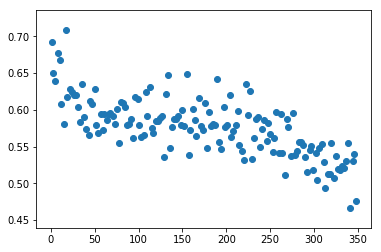

In [108]:
import matplotlib.pyplot as plt
plt.scatter(iterations, losses)
plt.show()

In [109]:
best_loss

0.4665854573249817

In [110]:
validation_pred.detach().max()

tensor(1.7892)

In [111]:
angle_tensor.shape

torch.Size([798, 1, 3, 1499])

In [112]:
len(trainloader)

7